# Goals and strategies

We give ourselves an image, which may have been altered by noise or by a linear transformation such as convolution by a gaussian kernel.

Let $X$ be the original image, without noise or transformation.

Let $A$ be a linear function, for example, convolution by a gaussian kernel, and let $\eta$ be a noise term, which may be a small gaussian white noise over the whole image. Then the transformed image $Z$ has the form:

$$Z = AX + \eta$$

If $A$ is invertible, and there is no noise ( $\eta = 0$ ), then 
$Z = AX$, and $X$ satisfies:

$$X = \mathrm{argmin}_{U}(\frac{1}{2}\|AU - Z\|^2_2)$$

Suppose now that $\eta$ is nonzero. We would also like to remove $\eta$ to find $X$, insofar as it is possible. The assumption that the noise is a gaussian white noise, implies that the noise has high frequency, whereas the original image should be more smooth: transitions from one pixel to the next should be smooth almost everywhere (a pixel of blue sky is probably surrounder by other blue pixels).


This peculiarity of a random noise leads us to consider a kind of discrete derivative on the image's horizontal and vertical dimensions, on which we will apply our penalty. More specifically, the difference operator $D$ acts on the array of pixels $(p[x,y])_{x,y}$ by returning the following quantity at position $(x,y)$
$$(p[x+1,y]-p[x-1,y], p[x,y+1]-p[x,y-1])$$

Applying an L1 norm to this quantity, we obtain the following loss function:

$$\ell(U, Z) = \frac{1}{2}\|AU - Z\|_2^2 + \lambda \|DU\|_1$$

Finally, we can constrain the optimization to a convex set $C$. To obtain this constraint, we just have to add the indicator function $\iota_C$, which will give the loss an infinite value outside $C$ and won't change the minimization problem inside $C$. In this way,

$$\mathrm{argmin}_{U}(\frac{1}{2}\|AU - Z\|_2^2 + \lambda \|DU\|_1 + \iota_C) = \mathrm{argmin}_{U, U\in C}(\frac{1}{2}\|AU - Z\|_2^2 + \lambda \|DU\|_1)$$

[ADD IMAGES FOR GAUSSIAN KERNEL AND GAUSSIAN WHITE NOISE]

[MOTIVATE THE USE OF THE L1 NORM, AND THE DOMAIN OF OPTIMIZATION C.]

[REMARQUE DE NELLY PUSTELNIK : ON PEUT REMPLACER L1 PAR L2 POUR EVITER ARTEFACTS, ET NE PAS PRENDRE C = BOULE CAR REDONDANCE AVEC NORME L2, ET CONTRAINDRE LA VALEUR DES PIXELS ENTRE 0 ET 1]

# Imports and opening images
Necessary dependencies

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import torchvision as tv
from IPython.display import display, clear_output
from tqdm import tqdm
from time import perf_counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Opening the images
Some parameters in our algorithms give different results depending on the image size. Therefore, we cast all our images into a square format with the same resolution.

In [3]:
from PIL import Image

def crop_and_downsample(image_path, size=(512, 512)):
    """
    Crop a PIL Image to a square shape and downsample it to the specified size.

    Parameters:
    image (PIL.Image): The input image.
    size (tuple, optional): The target size after downsampling, default is (512, 512).

    Returns:
    PIL.Image: The processed image.
    """
    image = Image.open(image_path)
    width, height = image.size

    crop_size = min(width, height)

    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2

    image_cropped = image.crop((left, top, right, bottom))
    image_downsampled = image_cropped.resize(size, Image.ANTIALIAS)
    image_downsampled = image_downsampled.convert("L")
    return image_downsampled

disc_image = crop_and_downsample("rond.jpg")

## Transforming to tensors

In [4]:
def image_to_tensor(image):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a tensor
    ])
    return transform(image)

disc_tensor = image_to_tensor(disc_image)

# Adding noise


Take an image, and add some noise to it.

Possible noises:
1. Gaussian white noise (not convolution by a fixed gaussian kernel)

OTHER NOISES ?

In [5]:
def gaussian_blur_and_noise(image, std_noise, gaussian_std=10, kernel_size=51, print_image=True,image_size=(900,900)):
    # Gaussian blur + noise
    # Show original
    printed_image = image.clone().detach()
    if print_image:
        print(f"original shape {printed_image.shape}")
    printed_image = transforms.ToPILImage()(printed_image).resize(image_size)
    if print_image:
        display(printed_image)
    noise = torch.randn(image.shape) * std_noise
    blurred_image = tv.transforms.functional.gaussian_blur(image, kernel_size=kernel_size, sigma=gaussian_std)
    noisy_image = blurred_image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    printed_image = noisy_image.clone().detach()
    if print_image:
        print(f"new shape {printed_image.shape}")
    printed_image = transforms.ToPILImage()(printed_image).resize(image_size)
    if print_image:
        display(printed_image)
    return noisy_image

# Difference operator
The difference operator is like a convolution by a particular kernel. We apply this difference operator along the vertical and horizontal dimensions.

In [6]:
#D et D^T

def GradientHor(x):
    y=x-torch.roll(x,1,dims=2)
    y[0,:,0]=0
    return y

def GradientVer(x):
    y=x-torch.roll(x,1,dims=1)
    y[0,0,:]=0
    return y

def DivHor(x):
    N=(x[0,0]).numel()
    y=x-torch.roll(x,-1,dims=2)
    y[0,:,0]=-x[0,:,1]
    y[0,:,N-1]=x[0,:,N-1]
    return y

def DivVer(x):
    N=len(x[0])
    y=x-torch.roll(x,-1,dims=1)
    y[0,0,:]=-x[0,1,:]
    y[0,N-1,:]=x[0,N-1,:]
    return y

def Psi(x):
    return torch.stack((GradientHor(x), GradientVer(x)))

def Psit(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x


# Approaches

## Adam

In [7]:
class FiniteDifference(nn.Module):
    def __init__(self):
        super().__init__()
        filter_horizontal = torch.tensor([
            [-1, 1],
            [0, 0]
        ], dtype=torch.float32).reshape(1, 1, 2, 2)
        filter_vertical = torch.tensor([
            [-1, 0],
            [1, 0]
        ], dtype=torch.float32).reshape(1, 1, 2, 2)
        filter_horizontal = filter_horizontal / torch.norm(filter_horizontal, p=2)
        filter_vertical = filter_vertical / torch.norm(filter_vertical, p=2)
        self.filter_horizontal = nn.Parameter(filter_horizontal, requires_grad=False)
        self.filter_vertical = nn.Parameter(filter_vertical, requires_grad=False)

    def forward(self, image):
        gradient_horizontal = torch.nn.functional.conv2d(image, self.filter_horizontal, padding=1)
        gradient_vertical = torch.nn.functional.conv2d(image, self.filter_vertical, padding=1)
        return gradient_horizontal, gradient_vertical

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size, sigma):
        super().__init__()
        self.gaussian_blur = tv.transforms.GaussianBlur(kernel_size, sigma)

    def forward(self, image):
        return self.gaussian_blur(image)

class ReconstructionLoss(nn.Module):
    def __init__(self, image, penalty_weight, gaussian_std, kernel_size):
        super().__init__()
        self.image = nn.Parameter(image, requires_grad=False)
        self.gaussian_blur = GaussianBlur(kernel_size=kernel_size, sigma=gaussian_std)
        self.finite_difference = FiniteDifference()
        reconstruction = image.clone().detach()
        self.reconstruction = nn.Parameter(reconstruction, requires_grad=True)
        self.penalty_weight = nn.Parameter(torch.tensor(penalty_weight), requires_grad=False)

    def forward(self):
        blurred_reconstruction = self.gaussian_blur(self.reconstruction)
        l2_loss = 1 / 2 * torch.norm(blurred_reconstruction - self.image, p=2) ** 2
        finite_difference_reconstruction_horizontal, finite_difference_reconstruction_vertical = self.finite_difference(
            self.reconstruction)
        l1_loss = torch.norm(finite_difference_reconstruction_horizontal, p=1) + torch.norm(
            finite_difference_reconstruction_vertical, p=1)
        return l2_loss + self.penalty_weight * l1_loss


In [8]:
kernel_size = 3
gaussian_std = 0.001
std_noise = 0.03
noisy_image = gaussian_blur_and_noise(disc_tensor, std_noise=std_noise, gaussian_std=gaussian_std, kernel_size=kernel_size, print_image=False)
# Now optimize the reconstruction module

def adam_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, lr=0.01, show_image = True, device=device):
    list_times = []
    list_losses = []
    reconstruction_module = ReconstructionLoss(noisy_image, penalty_weight=penalty_weight, gaussian_std=gaussian_std, kernel_size=kernel_size)
    optimizer = torch.optim.AdamW(reconstruction_module.parameters(), lr=lr)
    reconstruction_module.to('cuda')
    pbar = tqdm(range(epochs))
    for i in pbar:
        t_deb_iter = perf_counter()
        optimizer.zero_grad()
        loss = reconstruction_module()
        loss.backward()
        optimizer.step()
        t_end_iter = perf_counter()
        list_times.append(list_times)
        list_losses.append(loss.item())
        if i % 10 == 0:
            pbar.set_description(f"Loss: {loss.item():.9f}")

        if i % 200 == 199 and show_image:
            # Clear the previous output
            clear_output(wait=True)
            print(f"Epoch {i}, Loss: {loss.item()}")
            
            # Clone the tensor, detach it from the computation graph, and move it to CPU
            result = reconstruction_module.reconstruction.clone().detach().cpu()
            # Convert to PIL image
            pil_image = transforms.ToPILImage()(result).resize((900,900))
            # Display the image in the notebook
            display(pil_image)
    result = reconstruction_module.reconstruction.clone().detach().cpu()
    pil_image = transforms.ToPILImage()(result).resize((900,900))
    return pil_image, list_times, list_losses

In [9]:
image, list_times, list_losses = adam_optimization(10000, noisy_image, 0.05, 0.000001, 1, lr = 0.01, show_image=False, device = "cpu")

Loss: 176.790344238: 100%|██████████| 10000/10000 [00:06<00:00, 1488.48it/s]


## Condat-Vu

On considère le problème d'optimisation:
\begin{equation}
\min_{x \in \mathbb{R^{n \times n} }} \frac{1}{2} \|x-z \|_{2}^{2} + \lambda \| Dx \|_{1} + i_c(x)
\end{equation}
où $C = \{ u \in \mathbb{R}^{n \times n} | \|u-z \|_{2}^{2} \leq \sigma ^2 \} $, $\lambda >0$ et $D$ l'opérateur de différences finies.


Nous allons appliquer l'algorithme de Condat-Vu, avec $f= i_c$,$h = \frac{1}{2} \| \cdot -z \| _{2}^{2}$, $g=\| \cdot \|_{1}$ et $L = D$.


On calcule:

\begin{equation}
prox_{\tau f} (x) = P_{C}(x)
\end{equation}

\begin{equation}
prox_{\gamma g^{*}} (x) = (\varphi (x_i) )_{1 \leq i \leq n^2 }
\end{equation}

\begin{equation}
\nabla{h}(x) = x-z
\end{equation}
où:
\begin{equation}
\begin{array}{l|rcl}
\varphi : & \mathbb{R} & \longrightarrow & \mathbb{R} \\
    & x & \longmapsto & \begin{cases}-1 \text{ , si $x<-1$,} \\ x \text{ , si $|x| \leq 1$,} \\ 1 \text{ , si $x>1$,} \end{cases}
    \end{array}
    \end{equation}

In [10]:
#calcul des prox de f et g

def prox_f(x, z, sigma):
    diff = x - z
    norm_diff = torch.linalg.norm(diff)
    # Using torch.where for element-wise condition
    return torch.where(norm_diff > sigma, sigma * diff / norm_diff + z, x)

def prox_g(x):
    return torch.clamp(x, -1, 1)
#Condat-Vu

def condat_vu(x_0,v_0,z, n_max, tau, gamma, sigma):
    p = []
    q = []
    x = x_0
    v = v_0
    lambda_ = 1

    for n in range(n_max):
        p.append( prox_f( x[-1] - tau*(x[-1] -z + Psit(v[-1])), z, sigma))
        q.append( prox_g( v[-1] + gamma*( Psi(2*p[-1] - x[-1]) ) ) )
        x_temp,v_temp=x[-1],v[-1]
        x.append(x_temp + lambda_*(p[-1] - x_temp))
        v.append(v_temp + lambda_*(q[-1] - v_temp))
        print(n)
    return x

def loss(x, original_image, penalty):
    l2_squared_loss = 1/2 * torch.norm(x-original_image, p=2)**2
    l1_loss = penalty*torch.norm(Psi(x), p=1)
    return l2_squared_loss + l1_loss
def condat_vu_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, show_image = True, device = device,
                           tau = 0.1, gamma = 0.3, sigma = 100, lamb = 1):
    """Not taking the linear transformation A for now, contrary to the Adam version which
    used a gaussian blurring convolution."""
    list_times = [] # Time per iteration without computing loss.
    list_losses = [] # After each iteration, compute the loss.
    iter = tqdm(range(epochs))
    noisy_image = noisy_image.clone().detach().to(device)
    x = noisy_image.clone().detach().to(device)
    v = Psi(x)
    for i in iter:
        t_deb = perf_counter()

        p = prox_f(x - tau*(x-noisy_image+Psit(v)), noisy_image, sigma)
        q = prox_g(v + gamma*(Psi(2*p - x)))
        x = x + lamb*(p-x)
        v = v + lamb*(q-v)
        t_fin = perf_counter()
        list_times.append(t_fin-t_deb)
        list_losses.append(loss(x, noisy_image, penalty=penalty_weight).item())
    pil_image = transforms.ToPILImage()(x.clone().detach().cpu())
    if show_image:
        display(pil_image)
    return pil_image, list_times, list_losses

100%|██████████| 1000/1000 [00:01<00:00, 909.12it/s]


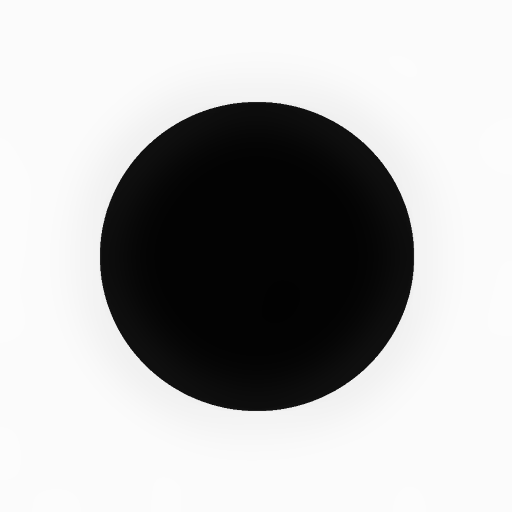

In [11]:
noisy_image = gaussian_blur_and_noise(disc_tensor, std_noise=std_noise, gaussian_std=gaussian_std, kernel_size=kernel_size, print_image=False)
pil_image, list_times, list_losses = condat_vu_optimization(epochs=1000, noisy_image=noisy_image, penalty_weight=0.1, gaussian_std=0.001, kernel_size=1, show_image=True, device="cpu")

## Projected gradient algorithm

In [12]:
def ball_projection(x, noisy_image, radius):
    """Projection onto a ball around noisy_image."""
    n = torch.norm(x-noisy_image, p="fro")
    if n <= radius:
        # x is already contained in the ball of radius "radius" around noisy_image
        return x
    else:
        y = (radius/n)*(x-noisy_image) + noisy_image
        return y

In [38]:
# Use the ReconstructionLoss module, but project after every iteration
def adam_projection_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, radius = 1, lr=0.01, show_image = True, device=device):
    list_times = []
    list_losses = []
    reconstruction_module = ReconstructionLoss(noisy_image, penalty_weight=penalty_weight, gaussian_std=gaussian_std, kernel_size=kernel_size)
    optimizer = torch.optim.AdamW(reconstruction_module.parameters(), lr=lr)
    reconstruction_module.to('cuda')
    noisy_image = noisy_image.to(device)
    pbar = tqdm(range(epochs))
    for i in pbar:
        t_deb_iter = perf_counter()
        optimizer.zero_grad()
        loss = reconstruction_module()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            reconstruction_module.reconstruction = nn.Parameter(ball_projection(reconstruction_module.reconstruction,
                                                                noisy_image,
                                                                radius))
        t_end_iter = perf_counter()
        list_times.append(list_times)
        list_losses.append(loss.item())
        if i % 10 == 0:
            pbar.set_description(f"Loss: {loss.item():.9f}")

        if i % 200 == 199 and show_image:
            # Clear the previous output
            clear_output(wait=True)
            print(f"Epoch {i}, Loss: {loss.item()}")
            
            # Clone the tensor, detach it from the computation graph, and move it to CPU
            result = reconstruction_module.reconstruction.clone().detach().cpu()
            # Convert to PIL image
            pil_image = transforms.ToPILImage()(result).resize((900,900))
            # Display the image in the notebook
            display(pil_image)
    result = reconstruction_module.reconstruction.clone().detach().cpu()
    pil_image = transforms.ToPILImage()(result).resize((900,900))
    return pil_image, list_times, list_losses

# Checking the convergence speed for each of the algorithms

Epoch 999, Loss: 7789.61083984375


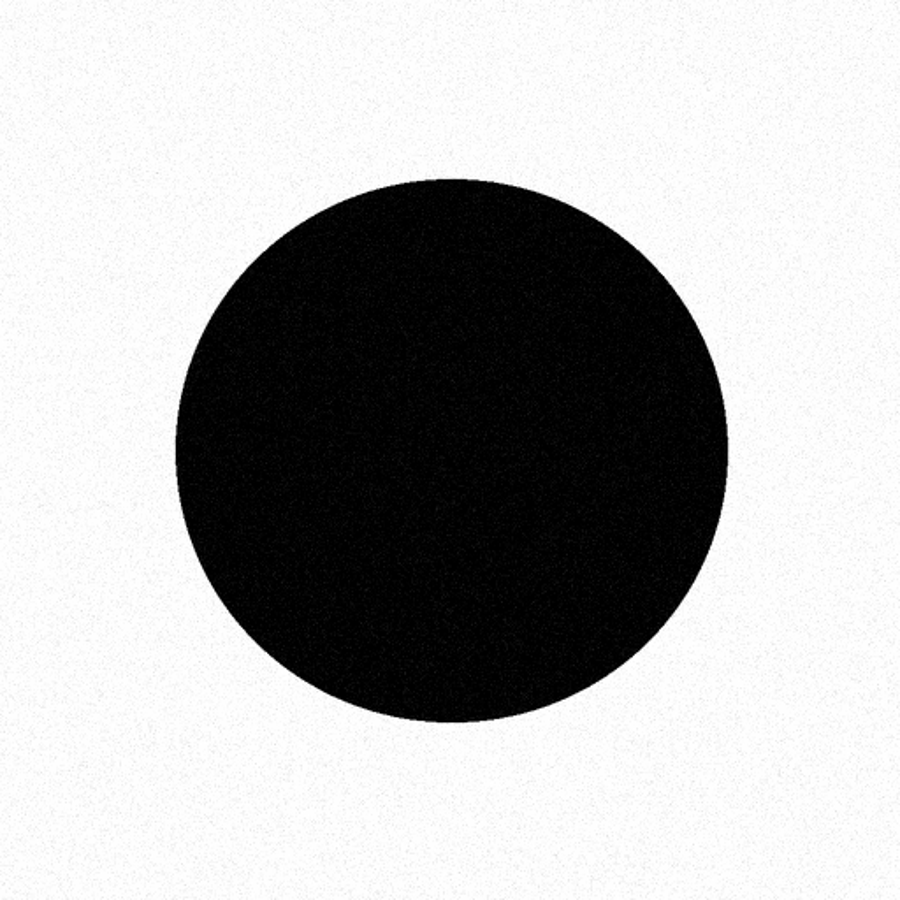

Loss: 7789.610839844: 100%|██████████| 1000/1000 [00:00<00:00, 1025.17it/s]


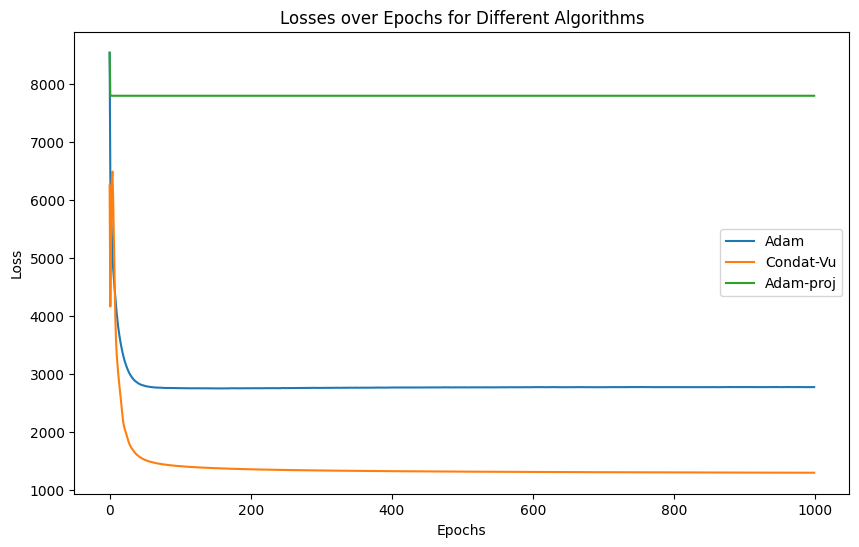

Image for algorithm Adam


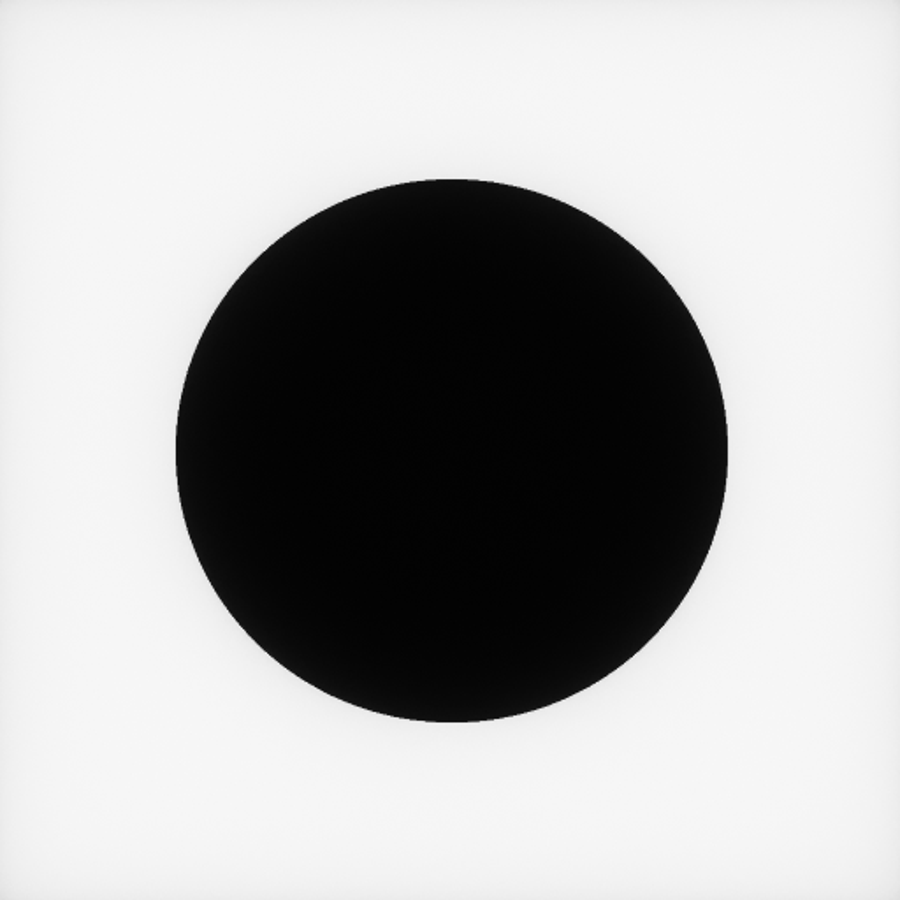

Image for algorithm Condat-Vu


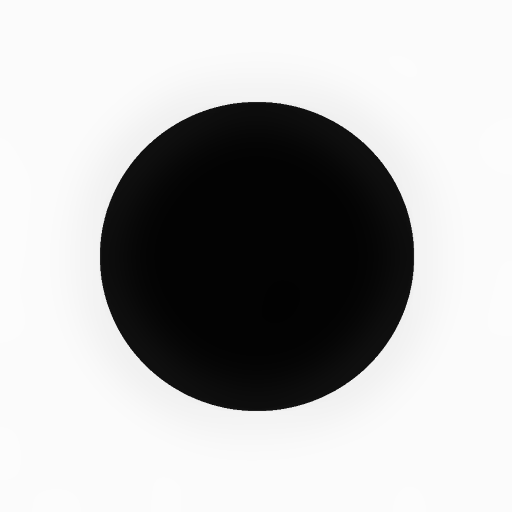

Image for algorithm Adam-proj


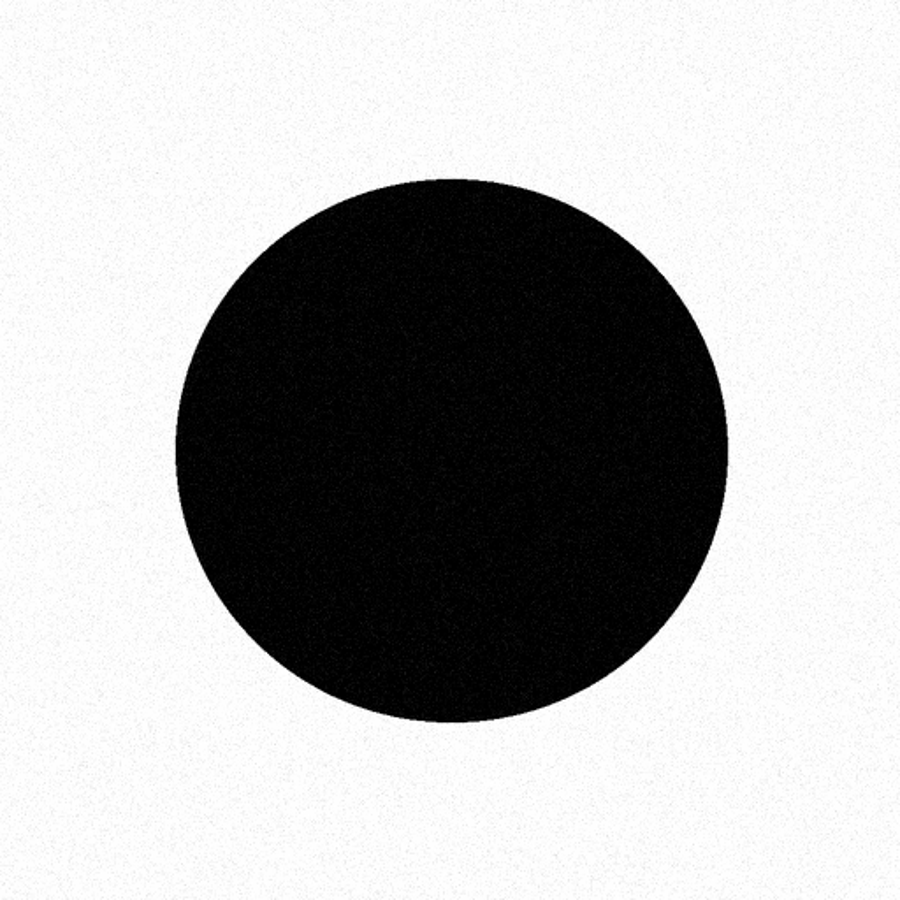

In [39]:
def accuracy_and_speed(list_algorithms, epochs, noisy_image, penalty_weight, gaussian_std, kernel_size, show_image=False, device=device):
    list_names = list_algorithms
    list_losses = []
    list_times = []
    list_total_times = []
    list_images = []
    for name in list_names:
        start_time = perf_counter()

        if name == "Adam":
            pil_image, times, losses = adam_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size)
        elif name == "Condat-Vu":
            pil_image, times, losses = condat_vu_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size)
        elif name == "Adam-proj":
            pil_image, times, losses = adam_projection_optimization(epochs, noisy_image, penalty_weight, gaussian_std, kernel_size)
        total_time = perf_counter() - start_time
        list_losses.append(losses)
        list_images.append(pil_image)
        list_times.append(times)
        list_total_times.append(total_time)

        if show_image:
            plt.imshow(pil_image)
            plt.title(f"Result with {name}")
            plt.show()
    return list_names, list_losses, list_times, list_images

list_names, list_losses, list_times, list_images = accuracy_and_speed(["Adam", "Condat-Vu", "Adam-proj"], 1000,noisy_image=noisy_image, penalty_weight=1, gaussian_std=0.001, kernel_size=1)
# Plotting losses
plt.figure(figsize=(10, 6))
for i, name in enumerate(list_names):
    plt.plot(list_losses[i], label=f"{name}")


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses over Epochs for Different Algorithms')
plt.legend()
plt.show()
for ind, image in enumerate(list_images):
    print(f"Image for algorithm {list_names[ind]}")
    display(image)